# M1
Karl Jacobsen

## Introduction

## Franke-function

We start by importing the necessary Python modules:

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
import seaborn
seaborn.set(style="white", context="notebook", font_scale=1.5,
            rc={"axes.grid": True, "legend.frameon": False,
"lines.markeredgewidth": 1.4, "lines.markersize": 10})
from collections import OrderedDict
from scipy import linalg
from numpy.linalg import norm
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

We create data and plot the Franke-function with these data:

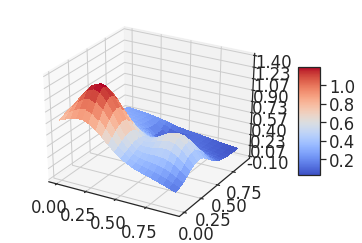

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

# Make data.
x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)
xPlot, yPlot = np.meshgrid(x,y)
z = FrankeFunction(xPlot, yPlot)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Next we make a class, that has methods for computaion of the OLS and Ridge estimator. In order to avoid problems with singularity during the matrix inversions in the OLS and Ridge estimators, the SVD is used. The class also contains methods for computation of errors, parameter variances and different resempling techniques.

In [3]:
class LeastSquares:
    """ 
    Least squares estimation of 2D function.
    Takes in meshgrid versions of x, y and z
    """
    
    def __init__(self, xPlot, yPlot, zPlot, degree, trueFunction=False, lambdaValue=None):
        if trueFunction:
            self.trueFunction = trueFunction
        if lambdaValue != None:
            self.lambdaValue = lambdaValue
        else:
            self.lambdaValue = 0.
        self.xOrg, self.yOrg = xPlot[0], yPlot[:,0]
        self.numberOfObservations = len(self.xOrg)
        self.xPlot, self.yPlot, self.zPlot = xPlot, yPlot, zPlot
        #self.x, self.y, self.z = xPlot.reshape(-1, 1), yPlot.reshape(-1, 1), zPlot.reshape(-1, 1)
        #self.x, self.y, self.z = np.ravel(xPlot), np.ravel(yPlot), np.ravel(zPlot)
        self.x, self.y, self.z = np.reshape(xPlot, -1, 1), np.reshape(yPlot, -1, 1), np.reshape(zPlot, -1, 1)

        self.degree = degree
        
    def createDesignMatrix(self):
        x, y = self.x, self.y
        #XHat = np.c_[x, y] 
        self.XHat = np.c_[x, y] 
        poly = PolynomialFeatures(self.degree)
        self.XHat = poly.fit_transform(self.XHat)
        #self.XHat = poly.fit_transform(XHat)

    def estimate(self):
        XHat = self.XHat
        XHatTdotXHatShape = np.shape(XHat.T.dot(XHat))
        
        # Ridge Inverson
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat) + \
         #                            lambdaValue*np.identity(XHatTdotXHatShape[0])).dot(XHat.T).dot(self.z)
        
        # OLS inversion
        #self.betaHat = np.linalg.inv(XHat.T.dot(XHat)).dot(XHat.T).dot(self.z)
        
        # Linear system OLS
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat), np.dot(XHat.T, self.z))
        
        # Linear system, Ridge. NOT WORKING.
        #self.betaHat = np.linalg.solve(np.dot(XHat.T, XHat) + lambdaValue*np.identity(XHatTdotXHatShape[0]),\
         #                              np.dot(XHat.T, self.z))
        
        
        # SVD Ridge
        alphas = np.zeros(1)
        alphas[0] = self.lambdaValue
        U, s, Vt = linalg.svd(self.XHat, full_matrices=False)
        d = s / (s[:, np.newaxis].T ** 2 + alphas[:, np.newaxis])
        self.betaHat = np.dot(d * U.T.dot(self.z), Vt).T
        self.betaHat = np.squeeze(self.betaHat)
        #print('shape beta ', np.shape(self.betaHat), 'type beta', type(self.betaHat))
        
    
    def predict(self):
        self.zPredict = self.XHat.dot(self.betaHat)

        
    def plot(self):
        xPlot, yPlot, zPlot = self.xPlot, self.yPlot, self.zPlot
        zPredict = self.zPredict
        #z = self.z
        zPredictPlot = (np.reshape(zPredict, np.shape(zPlot))).T
        #zPredictPlot = zPredictPlot.T
        
        # Plot
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPredictPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('Predicted')
        plt.show()
        
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False) 
        #ax.set_zlim(-1.50, 25.0)
        #ax.set_zlim(-0.10, 1.40)
        ax.zaxis.set_major_locator(LinearLocator(10))
        ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
        fig.colorbar(surf, shrink=0.5, aspect=5)
        ax.set_title('True')
        plt.show()        
        
        
    def calculateErrorScores(self):
        from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
        z, zPredict = self.z, self.zPredict
        self.mse = mean_squared_error(z, zPredict)
        self.r2 = r2_score(z, zPredict)
        
        #print("Mean squared error: %.4f" % self.mse)
        #print('R2 score: %.4f' % self.r2)
        

    def calculateVarianceBeta(self):
        XHat = self.XHat
        betaHat = self.betaHat
        z = self.z

        # Source Ridge estimator variance: https://arxiv.org/pdf/1509.09169.pdf
        shapeXXT = np.shape(XHat.T.dot(XHat))

        #yFitted = XHat.dot(betaHat)
        yFitted = self.zPredict
        mse = 1/(len(x) -1)*np.sum((z - yFitted)**2)

        coefficientVariancesSLR = np.linalg.inv(XHat.T.dot(XHat)).dot(mse)
        W = np.linalg.inv(XHat.T.dot(XHat) + self.lambdaValue*np.eye(shapeXXT[0], shapeXXT[1])).dot(XHat.T).dot(XHat) 
        self.varBeta = W.dot(coefficientVariancesSLR).dot(W.T)
        self.varBeta = np.diag(self.varBeta)
        #self.varBeta = np.diag(coefficientVariancesSLR)
        self.varOLS = np.diag(coefficientVariancesSLR)
        
    def movingAvg(self, array):
        n = len(array)
        cumsum  = np.cumsum(array)
        movingAverage  = np.cumsum(array)
        for counter in range(len(array)):
            movingAverage[counter] = cumsum[counter]/(counter+1)
        return movingAverage    
    
    def runningVariance(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns, numberOfBetas = np.shape(betaList)
        varianceMatrix = np.zeros((numberOfRuns, numberOfBetas))

        for runNumber in range(numberOfRuns):
            for betaNumber in range(numberOfBetas):
                varianceMatrix[runNumber, betaNumber] = np.var(betaList[0:runNumber+1, betaNumber])
        return varianceMatrix
    
    def runningVarianceVector(self, betaList):
        betaList = np.array(betaList)
        numberOfRuns = len(betaList)
        varianceVector = np.zeros(numberOfRuns)

        for runNumber in range(numberOfRuns):
            varianceVector[runNumber] = np.var(betaList[0:runNumber+1])
        return varianceVector
    
    

    
    def errorBootstrap(self, bootstraps=2, plot=False): 
        models = []
        
        self.mseBootstrap = np.zeros(bootstraps)
        self.R2Bootstrap = np.zeros(bootstraps)
        self.mseTraining = np.zeros(bootstraps)
        self.R2Training = np.zeros(bootstraps)
        
        self.bootstraps = bootstraps
        betaList = [] # For variance calculation
        #VBT = []
        self.error2 = np.zeros(bootstraps)
        #averageZ = 0
        zPredictDict = OrderedDict() # Bias-variance decomposition
        noiseDict = OrderedDict()
        noiseDict2 = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()

        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                zPredictDict[i, j]  = []
                noiseDict[i, j]      = []
                #noiseDict2[i, j]      = []
                totalErrorDict[i, j] = []
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        #varianceMatrix2 = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        #noiseMatrix2 = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)
        
        #avgYmatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        zPredictMeanMatrix = np.zeros((self.numberOfObservations, self.numberOfObservations))

        
        for iteration in range(self.bootstraps):
            zPredictMatrix = np.empty((self.numberOfObservations, self.numberOfObservations))
            zPredictMatrix[:] = np.nan
            # Training
            trainingIndices = [(np.random.randint(0, high=self.numberOfObservations), \
                      np.random.randint(0, high=self.numberOfObservations)) \
                     for i in range(self.numberOfObservations*self.numberOfObservations)]
            trainingIndices = np.array(trainingIndices)
            #print('\n trainingIndices \n', trainingIndices, '\n')
            '''
            xTraining1D = self.xPlot[trainingIndices[:,0], trainingIndices[:,1]]
            yTraining1D = self.yPlot[trainingIndices[:,0], trainingIndices[:,1]]
            zTraining1D = self.zPlot[trainingIndices[:,0], trainingIndices[:,1]]
            '''
            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]
            
            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D        
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
         
            # Testing
            testIndexArray = np.zeros((self.numberOfObservations, self.numberOfObservations))
            testIndexArray[trainingIndices[:,0], trainingIndices[:,1]] = 1
            testIndices = np.argwhere(testIndexArray == 0)
            #print('\n len(testIndices) \n', len(testIndices), '\n len(trainingIndices) \n', len(trainingIndices))
            '''
            xTest1D = self.xPlot[testIndices[:,0], testIndices[:,1]]
            yTest1D = self.yPlot[testIndices[:,0], testIndices[:,1]]
            zTest1D = self.zPlot[testIndices[:,0], testIndices[:,1]]
            '''
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            
            #print('\n xTest1D \n', xTest1D, '\n')
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            #self.estimate()
            self.predict()           # --> zPredict
            
            self.mseBootstrap[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Bootstrap[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                #noiseDict2[coordinate].append(self.z[index] - self.trueFunction(self.x[index], self.y[index]))# Always the same
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
                zPredictMatrix[coordinate[0]][coordinate[1]] = self.zPredict[index]
            models.append(zPredictMatrix)
            
            self.error2[iteration] = 0            
            for i in range(len(x)):
                self.error2[iteration] += (self.z[i] - self.zPredict[i])**2
            

        
        #zForTest = np.ravel(self.zPlot)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(zPredictDict, range(len(zPredictDict))):
            zPredictMean = np.nanmean(zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(zPredictDict[key])
            #varianceMatrix2[key[0], key[1]] = np.nanmean((zPredictDict[key] - zPredictMean)**2)
            #bias2Matrix[key[0], key[1]] = (zPredictMean - self.trueFunction(self.xOrg[key[0]], self.yOrg[key[1]]))**2
            #bias2Matrix[key[0], key[1]] = (zPredictMean - zForTest[index])**2
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            #noiseMatrix2[key[0], key[1]] = np.nanvar(noiseDict2[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]
                    
            zPredictMeanMatrix[key[0], key[1]] = np.nanmean(zPredictDict[key])

            

        #print('\n varianceMatrix/varianceMatrix2 \n', np.divide(varianceMatrix,varianceMatrix2), '\n ') 
        # Result: they equal
        
        #print('\n totalErrorMatrix/totalErrorMatrixForTesting \n', np.divide(totalErrorMatrix,totalErrorMatrixForTesting), '\n ') 
        # Result: different
        
        #print('\n noiseMatrix/noiseMatrix2 \n', np.divide(noiseMatrix,noiseMatrix2), '\n ') 
        # Result: Numbers ar 10**31
        
        #print('\n noiseMatrix2 \n',noiseMatrix2, '\n ') 
        # Very small elements, 10**-31 --> Reason: The difference between the real function and the data always the same
        
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        #self.variance2 = np.nanmean(np.reshape(varianceMatrix2, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        #print('\n bias2, variance, noise, sum(bias2, variance, noise), totalError', 
         #     self.bias2, self.variance, self.noise, self.bias2+ self.variance+self.noise, self.totalError) 
        
        #from numpy.linalg import norm
        variancePython = 0
        for prediction in models:
            #print('prediction ', prediction)
            for row in range(self.numberOfObservations):
                for col in range(self.numberOfObservations):
                    if not np.isnan(prediction[row][col]):
                        '''print('row, col, ', row, col, '\n zPredictMeanMatrix[row][col] \n', \
                             zPredictMeanMatrix[row][col], '\n prediction[row][col] \n', \
                             prediction[row][col]) '''
                        variancePython += (zPredictMeanMatrix[row][col] - prediction[row][col])**2
        variancePython = np.sqrt(variancePython)
        #print('\n fValues.size ', fValues.size, 'self.bootstraps ', self.bootstraps)
        variancePython /= fValues.size * self.bootstraps
        self.variancePython = variancePython
        
        zPredictMeanMatrix = np.reshape(zPredictMeanMatrix, -1, 1)
        bias_2 = norm(zPredictMeanMatrix - fValues)
        bias_2 /= fValues.size #example python
        self.biasPython = bias_2
        
        #betaList = np.array(betaList)
        self.error2 = np.sum(self.error2)
        self.mseBootStrapMA = self.movingAvg(self.mseBootstrap)
        self.R2BootstrapMA = self.movingAvg(self.R2Bootstrap)
        self.betaRunning = self.movingAvg(betaList)
        self.varianceBetaBootstrap =  self.runningVariance(betaList)
        self.varMSE = self.runningVarianceVector(self.mseBootstrap)
        #self.VBT = np.array(VBT)
        #self.totalVBT = self.VBT[:,-1]
        
        # Bias-variance for cases when true function unknown
        self.varianceMSERealData = np.var(self.mseBootstrap)
        self.meanMSEsquaredRealData = (np.mean(self.mseBootstrap))**2
        self.mseTotalRealData = norm(self.mseBootstrap)
        self.mseTotalRealData = self.mseTotalRealData**2/self.bootstraps
        '''
        print('\n var+bias \n', self.varianceMSERealData + self.meanMSEsquaredRealData, \
             '\n mseTotal \n', self.mseTotalRealData )'''
        
        
        if plot:
            fig, ax = plt.subplots()
            ax.plot(np.arange(1,len(self.mseBootStrapMA)+1), self.mseBootStrapMA)
            ax.set_title('Bootstrap \n Running Mean MSE')
            ax.set_xlabel('Number of bootsraps')
            ax.set_ylabel('Running mean MSE')
            
            fig4, ax4 = plt.subplots()
            ax4.plot(np.arange(1,len(self.mseBootStrapMA)+1), (self.varMSE/self.mseBootStrapMA)*100)
            ax4.set_title('Bootstrap \n Running (Variance MSE/Mean MSE)*100')
            ax4.set_xlabel('Number of bootsraps')
            ax4.set_ylabel('Running variance MSE')
            
            fig2, ax2 = plt.subplots()
            ax2.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.R2BootstrapMA )
            ax2.set_title('Bootstrap \n Running Mean R2')
            ax2.set_xlabel('Number of bootsraps')
            ax2.set_ylabel('Running Mean R2')
            
            fig3, ax3 = plt.subplots()
            ax3.plot(np.arange(1,len(self.R2BootstrapMA )+1), self.varianceBetaBootstrap )
            ax3.set_title('Bootstrap \n Var(Beta) (Running)')
            ax3.set_xlabel('Number of bootsraps')
            ax3.set_ylabel('Var(Beta)')
            
            '''
            fig5, ax5 = plt.subplots()
            ax5.plot(np.arange(1,len(self.R2BootstrapMA )+1),  self.betaRunning)
            ax5.set_title('Bootstrap \n Beta')
            ax5.set_xlabel('Number of bootsraps')
            ax5.set_ylabel('Beta')
            '''
            # HERE: 1) After reversal of index numbers, total error in bootstrap no longer sum of bias and viarnace
            # when zero noise, \
            #2) maybe possible use method as in pytjhon nb example. Just take average each
            # element.., 
            
    def kFold(self, numberOfFolds=3, shuffle=False):
        self.betaList = [] # For variance calculation
        self.zPredictDict = OrderedDict() # Bias-variance decomposition
        self.mseTraining = np.zeros(numberOfFolds)
        self.R2Training = np.zeros(numberOfFolds)        
        noiseDict = OrderedDict()
        totalErrorDict = OrderedDict()
        varianceDict = OrderedDict()
        self.mseSciKit = np.zeros(numberOfFolds)
        self.R2SciKit = np.zeros(numberOfFolds)
        bias2Matrix = np.zeros((self.numberOfObservations, self.numberOfObservations))
        varianceMatrix = np.zeros_like(bias2Matrix)
        noiseMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrix = np.zeros_like(bias2Matrix)
        totalErrorMatrixForTesting = np.zeros_like(bias2Matrix)    
        
        for i in range(self.numberOfObservations):
            for j in range(self.numberOfObservations):
                self.zPredictDict[i, j]   = []
                noiseDict[i, j]      = []
                totalErrorDict[i, j] = []
        
        if not shuffle:
            indices = []
            for i in range(self.numberOfObservations):
                for j in range(self.numberOfObservations):
                    indices.append((i,j))
            indices = np.array(indices)
        else:
            return None
        
        foldLength = int(round(self.numberOfObservations**2/numberOfFolds))
        
        for iteration in range(numberOfFolds):
            if iteration != range(numberOfFolds)[-1]:
                testIndices = indices[iteration*foldLength:(iteration+1)*foldLength]
            else:
                testIndices = indices[foldLength*iteration:]   
            
            
            xTest1D = self.xPlot[testIndices[:,1], testIndices[:,0]]
            yTest1D = self.yPlot[testIndices[:,1], testIndices[:,0]]
            zTest1D = self.zPlot[testIndices[:,1], testIndices[:,0]]
            '''
            print('\n testIndices \n',testIndices)
            print('\n xPlot \n',self.xPlot)
            print('\n xTest1D \n',xTest1D)

            print('\n testIndices \n',testIndices)
            print('\n yPlot \n',self.yPlot)
            print('\n yTest1D \n',yTest1D)
            '''
            
            indices_rows = indices.view([('', indices.dtype)] * indices.shape[1])
            testIndices_rows = testIndices.view([('', testIndices.dtype)] * testIndices.shape[1])
            trainingIndices = np.setdiff1d(indices_rows, testIndices_rows).view(indices.dtype).reshape(-1, indices.shape[1])          
            #print('\n trainingIndices \n',trainingIndices)
            #print('\n testIndices \n',testIndices)
            xTraining1D = self.xPlot[trainingIndices[:,1], trainingIndices[:,0]]
            yTraining1D = self.yPlot[trainingIndices[:,1], trainingIndices[:,0]]
            zTraining1D = self.zPlot[trainingIndices[:,1], trainingIndices[:,0]]

            self.x, self.y, self.z = xTraining1D, yTraining1D, zTraining1D      
            #print('\n self.x \n', self.x)
            
            self.createDesignMatrix() # --> XHat
            self.estimate()           # --> betaHat
            self.betaList.append(self.betaHat)
            self.predict()
            self.mseTraining[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2Training[iteration] = r2_score(self.z, self.zPredict)
            
            self.x, self.y, self.z = xTest1D, yTest1D, zTest1D
            self.createDesignMatrix()
            self.predict()           # --> zPredict
            self.mseSciKit[iteration] = mean_squared_error(self.z, self.zPredict)
            self.R2SciKit[iteration] = r2_score(self.z, self.zPredict)
            
            testIndicesTuple = tuple(map(tuple, testIndices))
            for coordinate, index in zip(testIndicesTuple, range(len(self.zPredict))):
                self.zPredictDict[coordinate].append(self.zPredict[index])
                noiseDict[coordinate].append((self.z[index] - self.trueFunction(self.x[index], self.y[index]))**2)
                totalErrorDict[coordinate].append((self.z[index] - self.zPredict[index])**2)
        #print('\n zPredictDict inside ', self.zPredictDict)
        xForFunction, yForFunction = np.ravel(self.xPlot), np.ravel(self.yPlot)
        fValues = self.trueFunction(xForFunction, yForFunction)
        for key, index in zip(self.zPredictDict, range(len(self.zPredictDict))):
            zPredictMean = np.nanmean(self.zPredictDict[key])
            varianceMatrix[key[0], key[1]] = np.nanvar(self.zPredictDict[key])
            bias2Matrix[key[0], key[1]] = (zPredictMean - fValues[index])**2
            noiseMatrix[key[0], key[1]] = np.nanmean(noiseDict[key])
            totalErrorMatrix[key[0], key[1]] = np.nanmean(totalErrorDict[key])
            totalErrorMatrixForTesting[key[0], key[1]] = varianceMatrix[key[0], key[1]] + bias2Matrix[key[0], key[1]]\
                                                        + noiseMatrix[key[0], key[1]]
            
        # bias-variance over all observations
        self.bias2 = np.nanmean(np.reshape(bias2Matrix, -1, 1))
        self.variance = np.nanmean(np.reshape(varianceMatrix, -1, 1))
        self.noise = np.nanmean(np.reshape(noiseMatrix, -1, 1))
        self.totalError = np.nanmean(np.reshape(totalErrorMatrix, -1, 1))
        self.totalErrorForTesting = np.nanmean(np.reshape(totalErrorMatrixForTesting, -1, 1))
        
        # Bias-variance for cases when true function unknown
        self.varianceMSERealData = np.var(self.mseSciKit)
        self.meanMSEsquaredRealData = (np.mean(self.mseSciKit))**2
        self.mseTotalRealData = norm(self.mseSciKit)
        self.mseTotalRealData = self.mseTotalRealData**2/numberOfFolds
        '''print('\n var+bias \n', self.varianceMSERealData + self.meanMSEsquaredRealData, \
             '\n mseTotal \n', self.mseTotalRealData )'''
        

### Test of linear regression in class
Before we turn to the analysis using the linear regression model, we first check whether the class above produces the same results as Sci-Kit learn. The following code, which also contains its results, show that the class above produces the same parameter estimates, the same predictions and the same errors as Ridge for both the OLS-estimator and the Ridge-estimator.

In [4]:
# Scitkit learn. Testing whether our code gives the same mse and R2 on the training set as scl.
from sklearn.linear_model import LinearRegression

x = np.arange(0, 1, .05)#0.05)
y = np.arange(0, 1, .05)#0.05)

xPlot, yPlot = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

zPlot = FrankeFunction(xPlot, yPlot)

x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


XHat = np.c_[x, y]
degree = 5
poly = PolynomialFeatures(degree)
XHat = poly.fit_transform(XHat)

regressionTypes = 'LS', 'Ridge'
for regressionType in regressionTypes:
    print('\n ##################Regression type: %s' %regressionType, '################## \n')
    if regressionType == 'LS':
        lambdaValue = None
        linreg = LinearRegression()
        linreg.fit(XHat, z)
        predictScitKit = linreg.predict(XHat)

    else:
        lambdaValue = 2
        linreg=linear_model.Ridge(alpha=lambdaValue, fit_intercept = False) #False
        #XHatSCL = np.c_[np.ones_like(x), x, y]
        #XHatSCL = np.c_[x, y]
        #XHatSCL = XHat
        #linreg.fit(XHatSCL, z)
        #predictScitKit = linreg.predict(XHatSCL)
    print('################### Sci-kit learn############################')
    
    linreg.fit(XHat, z)
    predictScitKit = linreg.predict(XHat)


    print('Intercept: ', linreg.intercept_)
    print('Coefficients: ', linreg.coef_)
    print("Mean squared error: %.4f" % mean_squared_error(z, predictScitKit))
    print('R2 score: %.4f' % r2_score(z, predictScitKit))

    print('\n################### My class############################')

    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
    ls.createDesignMatrix()
    ls.estimate()
    print('betaHat my class: ', ls.betaHat)
    ls.predict()
    ls.calculateErrorScores()
    print('Predictions: zPredict/predictScitKit \n', ls.zPredict/predictScitKit)


    '''
    ##############################PLOTS###################################
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Frankel')
    plt.show()

    predictScitKitPlot = np.reshape(predictScitKit, np.shape(yPlot)).T
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xPlot, yPlot, predictScitKitPlot/zPlot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('Sci-kit/Franke')
    plt.show()

    predictMyClassPlot = np.reshape(ls.zPredict, np.shape(yPlot)).T
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(xPlot, yPlot, predictMyClassPlot/zPlot, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('My class/Franke')
    plt.show()
    '''


 ##################Regression type: LS ################## 

################### Sci-kit learn############################
Intercept:  0.5481633661827785
Coefficients:  [  0.           5.74654984   2.99559795 -24.03100583 -11.2601328
  -5.9653651   25.93438393  33.66372884  18.50345617 -14.08913347
  -0.90760655 -42.65810161  -1.189173   -31.71166945  36.40198929
  -7.37090174  15.88544529   6.62934981  -5.92131254  18.508273
 -19.78809639]
Mean squared error: 0.0022
R2 score: 0.9730

################### My class############################
betaHat my class:  [  0.54816337   5.74654984   2.99559795 -24.03100583 -11.2601328
  -5.9653651   25.93438393  33.66372884  18.50345617 -14.08913347
  -0.90760655 -42.65810161  -1.189173   -31.71166945  36.40198929
  -7.37090174  15.88544529   6.62934981  -5.92131254  18.508273
 -19.78809639]
Predictions: zPredict/predictScitKit 
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

### OLS: Polynomial dregree
Having shown that the class reproduces Sci-Kit learn results for the linear regression mode, we continue by running the linear regression model for different polynomial degrees using the class. The following code produces all the results for the linear regression model.

In [5]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
noiseSize  = 0.
zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 5
degrees = np.arange(1, maxDegree+1)
bootstraps = 100
numberOfFolds = 10
biasBS, varianceBS, noiseBS, totalErrorBS, mseBS, mseTrainingBS, r2BS, biasPython , variancePython, mseAllBs, \
biasRealDataBS, varianceRealDataBS, totalMSErealDataBS = \
[], [], [], [], [], [], [], [], [], [], [], [], []
biasKF, varianceKF, noiseKF, totalErrorKF, mseKF, mseTrainingKF, \
r2KF, mseKFStd, biasRealDataKF, varianceRealDataKF, totalMSErealDataKF, betasKF, varBetasKF= \
[], [], [], [], [], [], [], [], [], [], [], [], []
R2training, mseTraining, varBetasTraining, betasTraining = [], [], [], []

for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    ls.createDesignMatrix()
    ls.estimate()
    ls.predict()
    ls.calculateErrorScores()
    ls.calculateVarianceBeta()
    mseTraining.append(ls.mse)
    R2training.append(ls.r2)
    varBetasTraining.append(ls.varBeta)
    betasTraining.append(ls.betaHat)
    
    lsBS = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsBS.errorBootstrap(bootstraps=bootstraps, plot=False)
    biasBS.append(lsBS.bias2)
    varianceBS.append(lsBS.variance)
    noiseBS.append(lsBS.noise)
    totalErrorBS.append(lsBS.totalError)
    mseBS.append(np.mean(lsBS.mseBootstrap))
    mseTrainingBS.append(np.mean(lsBS.mseTraining))
    r2BS.append(np.mean(lsBS.R2Bootstrap))
    biasPython.append(lsBS.biasPython)
    variancePython.append(lsBS.variancePython)
    biasRealDataBS.append(lsBS.meanMSEsquaredRealData)
    varianceRealDataBS.append(lsBS.varianceMSERealData)
    totalMSErealDataBS.append(lsBS.mseTotalRealData)
   
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    lsKF.calculateVarianceBeta()
    varBetasKF.append(lsKF.varBeta)
    biasKF.append(lsKF.bias2)
    varianceKF.append(lsKF.variance)
    noiseKF.append(lsKF.noise)
    totalErrorKF.append(lsKF.totalError)
    mseKF.append(np.mean(lsKF.mseSciKit))
    mseKFStd.append(np.std(lsKF.mseSciKit)/np.mean(lsKF.mseSciKit))
    mseTrainingKF.append(np.mean(lsKF.mseTraining))
    r2KF.append(np.mean(lsKF.R2SciKit))
    biasRealDataKF.append(lsKF.meanMSEsquaredRealData)
    varianceRealDataKF.append(lsKF.varianceMSERealData)
    totalMSErealDataKF.append(lsKF.mseTotalRealData)
    betasKF.append(lsKF.betaList)

### OLS. Parameter uncertainty
We will approximate the Franke function with polynomial regression. In order to decide which polynomial order to use, we make comparisons of the results using different polynomial degrees in the training. The comparisons will be made on error measures such as the Mean Squared Error (MSE) and the R2 score. But before we start with the analysis of the error measures, we'll take a look at how the variance of the estimated parameters depends on the polynomial degree. We will compare the standard deviation of the three first parameters in polynomial fits from degree one to degree five. The three first parameters were chosen, since these parameters appear inn all the polynomial fits. Furthermore, we will report the standard deviation divided by the absolute value of the corresponding parameter estimate. Comparing the ratios of standard deviation to parameter values allows us to say something more about the condidence intercal of the parameter. The next figure shows the standard deviation to parameter value for the three first parameters. 

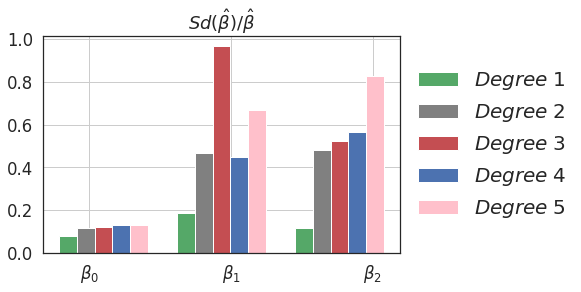

In [6]:
varBetasTrainingTobetasTraining = []
for i in range(len(varBetasTraining)):
    varBetasTrainingTobetasTraining.append(varBetasTraining[i]/np.abs(betasTraining[i]))

beta0 = np.zeros(len(varBetasTraining))
beta1 = np.zeros(len(varBetasTraining))
beta2 = np.zeros(len(varBetasTraining))
    
for i in range(len(varBetasTraining)):
    beta0[i] = np.sqrt(varBetasTrainingTobetasTraining[i][0])
    beta1[i] = np.sqrt(varBetasTrainingTobetasTraining[i][1])
    beta2[i] = np.sqrt(varBetasTrainingTobetasTraining[i][2])

#print('\n beta0 \n', beta0, '\n beta1 \n', beta1, '\n beta2 \n', beta2 )
    
variableNames = [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$' ]
fig2,ax2 = plt.subplots(figsize=(8,4))
numerOfVariables = 3
ind = np.arange(numerOfVariables)  
width = 0.15       # the width of the bars
rects1 = ax2.bar(ind, np.asarray([beta0[0], beta1[0], beta2[0]]), width, color='g')
rects2 = ax2.bar(ind+1*width, np.asarray([beta0[1], beta1[1], beta2[1]]), width, color='grey')
rects3 = ax2.bar(ind+2*width, np.asarray([beta0[2], beta1[2], beta2[2]]), width, color='r')
rects4 = ax2.bar(ind+3*width, np.asarray([beta0[3], beta1[3], beta2[3]]), width, color='b')
rects5 = ax2.bar(ind+4*width, np.asarray([beta0[4], beta1[4], beta2[4]]), width, color='pink')

#ax2.set_xlabel(r'$$')
#ax2.set_ylabel(r"$C_d$")
fontSize = 20
ax2.set_title(r'$Sd(\hat{\beta})/\hat{\beta}$')
ax2.set_xticks((ind + width)*1.2 )#/ 2)
ax2.set_xticklabels(variableNames)
legends = [r'$Degree \; 1$',r'$Degree\;  2$' , r'$Degree\;  3$', r'$Degree \; 4$', r'$Degree \; 5$'   ]
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax2.legend(legends, loc='center left', bbox_to_anchor=(1, 0.5)\
           , fontsize = fontSize)
#ax2.set_ylim(.08, .11)

From the figure above we see that the uncertainty in the paremeter estimates trypically grows with the model complexity. In other words, the confidence intervals broaden with the polynomial degree. For normal distributed variables, a 95 per cent confidence interval is approximately $[\hat{beta} - 2 Sd(\beta), \hat{beta} + 2 Sd(\beta)$. The values in the figure above suggests that the limits of the confidence interval's are at the size of the parameter's themselves, suggesting that the parameter estimates are very uncertain. The finding of increased parameter uncertainty with model compliexity we will return to again soon in the cross-validation discussion. 

### OLS. Error analysis
As promised before the discussion about parameter variance, we will now study MSE and R2. In the study of modell performance, it is crusial to distinguiss between performance measured on a test set and on the training data itself. \By comparing the performance of different polynomial degrees by MSE and R2 from traning data, one will probaly not find the best model. The error measures for the training data typically always decreases with the complexity of the model, leading to the false conclusion that the more complex the model, the better. The problem with a highly complex model, is that the predictions from this model will be highly variable with the input. A model very senesitive to the input data, does not generalize well, meaning that the model does not work well for other data than the data it was created with. This problem is called overfitting. <br>

Overfitting can be measured by measruing the preiction error from a given model on data that was not used in estimating the model. We split the data in training and test sets. Techniques for splitting the data in test and training sets are called resampling techniques. <br>

We will apply two different resampling techniques: K-fold and Bootstrapping. With the F-fold method, the data is split in K number of folds. One of the folds are chosen as the testing set, while the remaining folds are used for traning the model. This is repeated K number of times, each time with a different fold as the test set. We get K models, and we compute the error measures for all of them. Finally we averge the error measures over the models, getting scalars for the error measures for the given polynoial degree. <br>

With Bootstrapping, the other resampling technique, the data set is split into test and tranining set by random drawing. The tranining observations are drawn from the full dataset, with replacement. The number of observations in the training set equals the number of observations in the full data set. The replacement and the size of the training set implies that there almost always will be duplicats in the training set. The observations not contained in the training set makes up the test set. Typcally the split is 65/35 for training/test observations.<br>

The following code produce figures for $MSE_{training}$,  $MSE_{testing},\; R2_{training}$ and $R2_{testing}$ as functions of the polynomial degree.

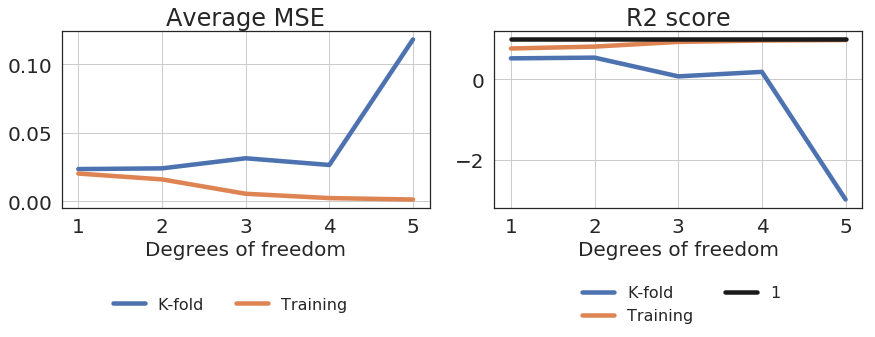

In [8]:
fig, (ax,ax2) = plt.subplots(1,2, figsize=(12.5,5))  # 1 row, 2 columns
fontSize  = 16
legends = ['K-fold', 'Training'] #, 'Bootstrap MSE', 'K-fold MSE'
legendsR2 = ['K-fold', 'Training', '1']
mseMethods =  mseKF, mseTraining
r2Methods = r2KF , R2training
xTicks = np.arange(1,maxDegree+1, 1)
lastDegree = 5

for mseMethod, r2Method, label in zip(mseMethods, r2Methods, legends): # mseTrainingBS, mseTrainingKF,
    ax.plot(degrees[:lastDegree], mseMethod[:lastDegree])#, label=label)
    ax2.plot(degrees[:lastDegree], r2Method[:lastDegree])#, label=label)
ax2.plot(degrees[:lastDegree], np.ones(len(degrees[:lastDegree])), 'k')
    
#ax2.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree]))
#ax2.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree]))


ax.set_title('Average MSE', fontsize = fontSize*1.5)
ax2.set_title('R2 score', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax2.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(xTicks)
ax2.set_xticks(xTicks)
legendsAx2 = [r'$Bias^2$', 'Variance']


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(0.1, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)


box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax2.legend(legendsR2, loc='center left', bbox_to_anchor=(0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax2.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
plt.tight_layout()

The figure to the left above shows that for the training set the MSE always decreases with the degrees of freedom. We also see that the K-fold method gives higher MSE compared to the training set. Contrary to the training MSE, the K-fold MSE reaches a point where more complexity with regards to polynomial degree does not make the fit better. The best polynomial degree seems to be everything below 5, since the MSE of the K-fold method is pretty constant in this range. <br>

Another way to study the fit, is by computation of the so-called R2-score. An R2-score equalt to one is a perfect fit, and the R2 is normally between zero and one. The figure to the right above shows the same story as the figure to the left. Furthermore, we see that the quality of the fit for the training set becomes extremely good, since the R2-score approaches one when the degrres of freedom increse. The R2 score for the K-fold method actually becomes negative, which is a rather seldom phenomenon, suggesting that the fit is no longer good. <br>

The reason for the increase in MSE with complexity has to do with increased variance due with model complexity. When the model is complex, a small change in the data will affect the estimation results to a high degree. Hence the MSE will vary a lot between the different folds in the K-fold validations when the model is complex. The following code produces a figure, where we have decoposed the MSE of all MSE's at given degrees of freedom into contributions from the squared bias and the variance, showing the contributing factors behind the change in MSE. 

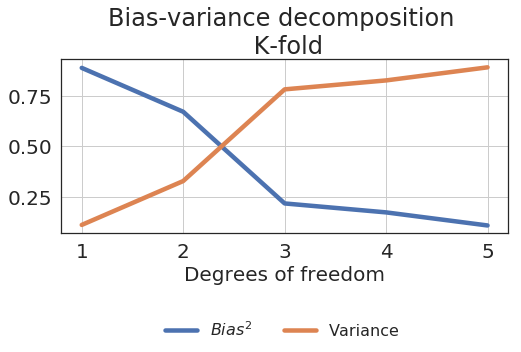

In [9]:
legends = ['K-fold', 'Training'] #, 'Bootstrap MSE', 'K-fold MSE'
r2Methods = r2KF , R2training


xTicks = np.arange(1,maxDegree+1, 1)
lastDegree = 5

fig, ax = plt.subplots(figsize=(8,4))
#for r2Method, label in zip( r2Methods, legends): # mseTrainingBS, mseTrainingKF,
 #   ax.plot(degrees[:lastDegree], r2Method[:lastDegree])#, label=label)
ax.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
ax.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree])/np.array(totalMSErealDataKF[:lastDegree]))
#ax.plot(degrees[:lastDegree], np.array(biasRealDataKF[:lastDegree]))
#ax.plot(degrees[:lastDegree], np.array(varianceRealDataKF[:lastDegree]))

ax.set_title('Bias-variance decomposition \n K-fold', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(xTicks)
legendsAx2 = [r'$Bias^2$', 'Variance', '1']


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legendsAx2, loc='center left', bbox_to_anchor=(0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})
#plt.tight_layout()

The figure shows that the bias contribution to the K-folds MSE decreeses, while the variance constribution increases, with the degrees of freedom. This observation, reduced bias and increased variance with complexity, is classical for overfitting. 

### Ridge and Lasso regression
Ridge and Lasso regression differs from OLS by including a punishment term in the cost-function. When model complexity is becoming large in the OLS-problem, giving overfitting, the design matrix becomes singular. By adding the penalty term the design matrix becomes invertible and Ridge and Lasso regression gives solutions. <br>

For Ridge regression the penalty term equals the squared absolute value of coefficients times a chosen parameter, while for Lasso the penalty term equals the absolute value of coefficients times a chosen parameter. In contrast to Ridge regression, Lasso can give parameter values equal to zero, which is practical when determining relevant predictors. <br>

The following code produces figures for comparing training MSE between three models, the testing MSE between the three models and the bias-variance distribution of the three models. As punishment parameters we have chosen $\lambda =1 $ for Ridge and $\lambda = 0.001$ for Lasso. For OLS and Ridge our own class is applied, while Sci-Kit learn is applied for Lasso.

In [10]:
def mseAllModels(noise=None):
    
    def biasVariance(mses):
        varianceMse = np.var(mses)
        meanMseSquared = (np.mean(mses))**2
        mseTotal = varianceMse + meanMseSquared
        return varianceMse, meanMseSquared, mseTotal

    np.random.seed(1)
    observationNumber = 20
    x = np.random.rand(observationNumber, 1)
    x = np.sort(x, 0)
    y = np.random.rand(observationNumber, 1)
    y = np.sort(y, 0)
    xPlot, yPlot = np.meshgrid(x,y)
    zPlot = FrankeFunction(xPlot, yPlot)
    if noise==None:
        noiseSize= 0
    else:
        noiseSize  = noise
    zPlot = frankeNoise(zPlot, noiseSize)

    maxDegree = 5
    degrees =np.arange(1, maxDegree+1)
    bootstraps = 100
    numberOfFolds = 10

    biasBS, varianceBS, noiseBS, totalErrorBS, mseBS, mseTrainingBS, r2BS, biasPython , variancePython, mseAllBs, \
    biasRealDataBS, varianceRealDataBS, totalMSErealDataBS = \
    [], [], [], [], [], [], [], [], [], [], [], [], []

    biasKFLs, varianceKFLs, noiseKFLs, totalErrorKFLs, mseKFLs, mseTrainingKFLs, \
    r2KFLs, mseKFStdLs, biasRealDataKFLs, varianceRealDataKFLs, totalMSErealDataKFLs, betasKFLs, varBetasKFLs= \
    [], [], [], [], [], [], [], [], [], [], [], [], []

    biasKFRidge, varianceKFRidge, noiseKFRidge, totalErrorKFRidge, mseKFRidge, mseTrainingKFRidge, \
    r2KFRidge, mseKFStdRidge, biasRealDataKFRidge, varianceRealDataKFRidge, totalMSErealDataKFRidge,\
    betasKFRidge, varBetasKFRidge= \
    [], [], [], [], [], [], [], [], [], [], [], [], []

    biasKFLasso, varianceKFLasso, noiseKFLasso, totalErrorKFLasso, mseKFLasso, mseTrainingKFLasso, \
    r2KFLasso, mseKFStdLasso, biasRealDataKFLasso, varianceRealDataKFLasso, totalMSErealDataKFLasso,\
    betasKFLasso, varBetasKFLasso= \
    [], [], [], [], [], [], [], [], [], [], [], [], []

    R2trainingLs, mseTrainingLs, varBetasTrainingLs, betasTrainingLs = [], [], [], []
    R2trainingRidge, mseTrainingRidge, varBetasTrainingRidge, betasTrainingRidge= [], [], [], []
    R2trainingLasso, mseTrainingLasso, varBetasTrainingLasso, betasTrainingLasso= [], [], [], []

    ridgeLambda = 1
    lassoLambda = .001


    for degree in degrees:
        lsTrain = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=None)
        lsTrain.createDesignMatrix()
        lsTrain.estimate()
        lsTrain.predict()
        lsTrain.calculateErrorScores()
        lsTrain.calculateVarianceBeta()
        mseTrainingLs.append(lsTrain.mse)
        R2trainingLs.append(lsTrain.r2)
        varBetasTrainingLs.append(lsTrain.varBeta)
        betasTrainingLs.append(lsTrain.betaHat)

        ridgeTrain = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=ridgeLambda)
        ridgeTrain.createDesignMatrix()
        ridgeTrain.estimate()
        ridgeTrain.predict()
        ridgeTrain.calculateErrorScores()
        ridgeTrain.calculateVarianceBeta()
        mseTrainingRidge.append(ridgeTrain.mse)
        R2trainingRidge.append(ridgeTrain.r2)
        varBetasTrainingRidge.append(ridgeTrain.varBeta)
        betasTrainingRidge.append(ridgeTrain.betaHat)

        lasso=linear_model.Lasso(alpha=lassoLambda, fit_intercept=False, max_iter=10000)
        polyLasso = PolynomialFeatures(degree)
        XHatLasso = np.c_[np.reshape(xPlot, -1, 1), np.reshape(yPlot, -1, 1)] 
        XHatLasso = polyLasso.fit_transform(XHatLasso)
        lasso.fit(XHatLasso, np.reshape(zPlot, -1, 1))
        zPredictLasso = lasso.predict(XHatLasso)
        mseTrainingLasso.append(mean_squared_error(np.reshape(zPlot, -1, 1), zPredictLasso))


        lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
        lsKF.kFold(numberOfFolds=numberOfFolds)
        lsKF.calculateVarianceBeta()
        varBetasKFLs.append(lsKF.varBeta)
        biasKFLs.append(lsKF.bias2)
        varianceKFLs.append(lsKF.variance)
        noiseKFLs.append(lsKF.noise)
        totalErrorKFLs.append(lsKF.totalError)
        mseKFLs.append(np.mean(lsKF.mseSciKit))
        mseKFStdLs.append(np.std(lsKF.mseSciKit)/np.mean(lsKF.mseSciKit))
        mseTrainingKFLs.append(np.mean(lsKF.mseTraining))
        r2KFLs.append(np.mean(lsKF.R2SciKit))
        biasRealDataKFLs.append(lsKF.meanMSEsquaredRealData)
        varianceRealDataKFLs.append(lsKF.varianceMSERealData)
        totalMSErealDataKFLs.append(lsKF.mseTotalRealData)
        betasKFLs.append(lsKF.betaList)

        ridgeKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue = ridgeLambda)
        ridgeKF.kFold(numberOfFolds=numberOfFolds)
        ridgeKF.calculateVarianceBeta()
        varBetasKFRidge.append(ridgeKF.varBeta)
        biasKFRidge.append(ridgeKF.bias2)
        varianceKFRidge.append(ridgeKF.variance)
        noiseKFRidge.append(ridgeKF.noise)
        totalErrorKFRidge.append(ridgeKF.totalError)
        mseKFRidge.append(np.mean(ridgeKF.mseSciKit))
        mseKFStdRidge.append(np.std(ridgeKF.mseSciKit)/np.mean(ridgeKF.mseSciKit))
        mseTrainingKFRidge.append(np.mean(ridgeKF.mseTraining))
        r2KFRidge.append(np.mean(ridgeKF.R2SciKit))
        biasRealDataKFRidge.append(ridgeKF.meanMSEsquaredRealData)
        varianceRealDataKFRidge.append(ridgeKF.varianceMSERealData)
        totalMSErealDataKFRidge.append(ridgeKF.mseTotalRealData)
        betasKFRidge.append(ridgeKF.betaList)


        lassoKF = linear_model.Lasso(alpha=lassoLambda, fit_intercept=False, max_iter=10000)
        lasso_scores = -cross_val_score(lassoKF, XHatLasso, np.reshape(z, -1, 1),
                                 scoring="neg_mean_squared_error", cv=numberOfFolds)  
        #varBetasKFRidge.append(ridgeKF.varBeta)
        #biasKFRidge.append(ridgeKF.bias2)
        #varianceKFRidge.append(ridgeKF.variance)
        #noiseKFRidge.append(ridgeKF.noise)
        #totalErrorKFRidge.append(ridgeKF.totalError)
        mseKFLasso.append(np.mean(lasso_scores))
        #mseKFStdRidge.append(np.std(ridgeKF.mseSciKit)/np.mean(ridgeKF.mseSciKit))
        #mseTrainingKFRidge.append(np.mean(ridgeKF.mseTraining))
        #r2KFRidge.append(np.mean(ridgeKF.R2SciKit))
        varianceMseLasso, meanMseSquaredLasso, mseTotalLasso = biasVariance(lasso_scores)
        biasRealDataKFLasso.append(meanMseSquaredLasso)
        varianceRealDataKFLasso.append(varianceMseLasso)
        totalMSErealDataKFLasso.append(mseTotalLasso)
        #betasKFRidge.append(ridgeKF.betaList)

    # Plotting
    fig, (ax,ax2, ax3) = plt.subplots(1,3, figsize=(12.5,5))  # 1 row, 2 columns
    fontSize  = 16
    legends = ['OLS', r'Ridge $\lambda=$ %g' %ridgeLambda, 'Lasso']# r'Lasso $\lambda=$ %g' %lassoLambda] #, 'Bootstrap MSE', 'K-fold MSE'
    legends = ['OLS','Ridge', 'Lasso']

    mseMethods =  mseTrainingLs, mseTrainingRidge, mseTrainingLasso
    mseMethodsTesting =  mseKFLs, mseKFRidge, mseKFLasso
    biasVariance =  np.array(varianceRealDataKFLs)/np.array(totalMSErealDataKFLs), \
                    np.array(varianceRealDataKFRidge)/np.array(totalMSErealDataKFRidge),\
                    np.array(varianceRealDataKFLasso)/np.array(totalMSErealDataKFLasso)
    xTicks = np.arange(1,maxDegree+1, 1)
    lastDegree = 5

    for trainingMethod, testingMethod, bvModel, label in zip(mseMethods, mseMethodsTesting, biasVariance, legends): # mseTrainingBS, mseTrainingKF,
        ax.plot(degrees[:lastDegree], trainingMethod[:lastDegree])#, label=label)
        ax2.plot(degrees[:lastDegree], testingMethod[:lastDegree])#, label=label)
        ax3.plot(degrees[:lastDegree], bvModel[:lastDegree])


    ax.set_title('Training MSE ', fontsize = fontSize*1.25)
    ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
    ax.set_xticks(xTicks)

    ax2.set_title('Mean testing MSE', fontsize = fontSize*1.25)
    ax2.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
    ax2.set_xticks(xTicks)

    ax3.set_title('Variance share test MSE', fontsize = fontSize*1.25)
    ax3.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
    ax3.set_xticks(xTicks)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
    ax.legend(legends, loc='center left', bbox_to_anchor=(-0.1, -0.45), \
               fontsize = fontSize, ncol=2)
    ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)


    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
    ax2.legend(legends, loc='center left', bbox_to_anchor=(-0.1, -0.45), \
               fontsize = fontSize, ncol=2)
    ax2.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
    #seaborn.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 4.5})

    box = ax3.get_position()
    ax3.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
    ax3.legend(legends, loc='center left', bbox_to_anchor=(-0.1, -0.45), \
               fontsize = fontSize, ncol=2)
    ax3.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
    if noise !=None:
        fig.suptitle('Noise = %g' %noise, fontsize = fontSize*1.25)
        fig.subplots_adjust(top=0.88)#88
    else:
        plt.tight_layout()
    plt.tight_layout()

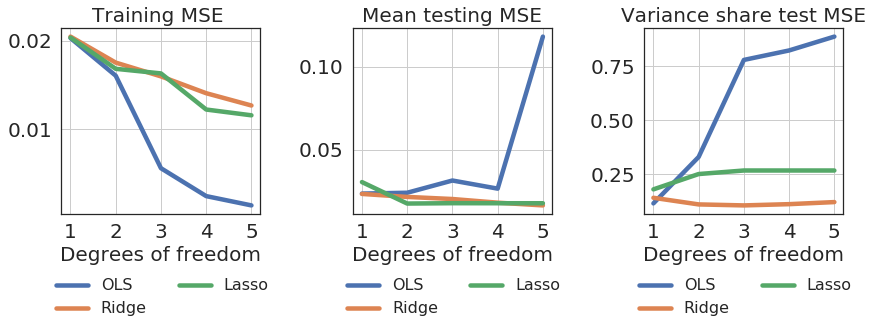

In [11]:
mseAllModels()

From the figure to the left above we see that the training error is always lowest for the OLS-model. It was expected that the training error was lowest for the OLS model, because OSL minimizes the training error, while the other model minimizes different cost-functions than the training error. <br>

In the middle figure above, we see that the rankings of model performance is turned around when one measures the model performance on test sets. 10-fold cross validation has been used. Now the OLS estimator performs worst. We see that in contrast to OLS, the Ridge and the Lasso model do not get the sudden explosion in test MSE when the degree become five. The punishment terms makes the Ridge and the Lasso estimators avoid the problem with nearly singular matrices when the model complexity gets high. <br>

The figure to the right, which shows the variance share of total MSE, illustrats the effect of the punishment terms in the Ridge and the Lasso estimators. The punishment term reduces the test MSE by reducing the variance. When the punishment term is large, there is a large punishment for large parameter values. Hence the parameter values are pressed down a lot when the punishment term is large. With lower parameter values, the models react less when applied to new test sets. Hence the variance contribution to MSE is reduced with the introduction of penalty terms.<br>

The middle figure above suggests that the complexity can increase even more when applying the Ridge or the Lasse estimators. Without looking at the coefficient values, it can be misleading only looking at the degrees of freedom number to determine the optimal degrees of freedom. With Ridge and Lasso, several parameters can be close to zero, so that the effective degrees of freedom is less than what was sent into the model. This is a strength with the Ridge and Lasso estimator's. We can use high degrees of freedom, and the models themselves decides which of the parameters it will actually use, so we migth avoid doing this degrees of freedom analysis that we have done til now. <br>

A natural next question is to ask about the optimal size of the punishment parameters. We will now study this question by solving the models for different values of punishment parameters. 

In [18]:
# Data for analysis of punishment parameter 

def biasVariance(mses):
    varianceMse = np.var(mses)
    meanMseSquared = (np.mean(mses))**2
    mseTotal = varianceMse + meanMseSquared
    return varianceMse, meanMseSquared, mseTotal

degree = 5
bootstraps = 100
numberOfFolds = 10

biasBS, varianceBS, noiseBS, totalErrorBS, mseBS, mseTrainingBS, r2BS, biasPython , variancePython, mseAllBs, \
biasRealDataBS, varianceRealDataBS, totalMSErealDataBS = \
[], [], [], [], [], [], [], [], [], [], [], [], []

biasKFLs, varianceKFLs, noiseKFLs, totalErrorKFLs, mseKFLs, mseTrainingKFLs, \
r2KFLs, mseKFStdLs, biasRealDataKFLs, varianceRealDataKFLs, totalMSErealDataKFLs, betasKFLs, varBetasKFLs= \
[], [], [], [], [], [], [], [], [], [], [], [], []

biasKFRidge, varianceKFRidge, noiseKFRidge, totalErrorKFRidge, mseKFRidge, mseTrainingKFRidge, \
r2KFRidge, mseKFStdRidge, biasRealDataKFRidge, varianceRealDataKFRidge, totalMSErealDataKFRidge,\
betasKFRidge, varBetasKFRidge= \
[], [], [], [], [], [], [], [], [], [], [], [], []

biasKFLasso, varianceKFLasso, noiseKFLasso, totalErrorKFLasso, mseKFLasso, mseTrainingKFLasso, \
r2KFLasso, mseKFStdLasso, biasRealDataKFLasso, varianceRealDataKFLasso, totalMSErealDataKFLasso,\
betasKFLasso, varBetasKFLasso= \
[], [], [], [], [], [], [], [], [], [], [], [], []

R2trainingLs, mseTrainingLs, varBetasTrainingLs, betasTrainingLs = [], [], [], []
R2trainingRidge, mseTrainingRidge, varBetasTrainingRidge, betasTrainingRidge= [], [], [], []
R2trainingLasso, mseTrainingLasso, varBetasTrainingLasso, betasTrainingLasso= [], [], [], []

startLambdaRidge = 0.05
startLambdaLasso = 0.000125
numberOfPoints = 6

ridgeLambdas = np.array([startLambdaRidge*1.5**i for i in range(numberOfPoints)]) #np.arange(0.0025, 0.015+ 0.0025, 0.0025)
lassoLambdas = np.array([startLambdaLasso*1.5**i for i in range(numberOfPoints)]) #np.arange(0.0025, 0.015+ 0.0025, 0.0025)


for ridgeLambda, lassoLambda in zip(ridgeLambdas, lassoLambdas):
    lsTrain = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=None)
    lsTrain.createDesignMatrix()
    lsTrain.estimate()
    lsTrain.predict()
    lsTrain.calculateErrorScores()
    lsTrain.calculateVarianceBeta()
    mseTrainingLs.append(lsTrain.mse)
    R2trainingLs.append(lsTrain.r2)
    varBetasTrainingLs.append(lsTrain.varBeta)
    betasTrainingLs.append(lsTrain.betaHat)
    
    ridgeTrain = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=ridgeLambda)
    ridgeTrain.createDesignMatrix()
    ridgeTrain.estimate()
    ridgeTrain.predict()
    ridgeTrain.calculateErrorScores()
    ridgeTrain.calculateVarianceBeta()
    mseTrainingRidge.append(ridgeTrain.mse)
    R2trainingRidge.append(ridgeTrain.r2)
    varBetasTrainingRidge.append(ridgeTrain.varBeta)
    betasTrainingRidge.append(ridgeTrain.betaHat)
    
    lasso=linear_model.Lasso(alpha=lassoLambda, fit_intercept=False, max_iter=100000)
    polyLasso = PolynomialFeatures(degree)
    XHatLasso = np.c_[np.reshape(xPlot, -1, 1), np.reshape(yPlot, -1, 1)] 
    XHatLasso = polyLasso.fit_transform(XHatLasso)
    lasso.fit(XHatLasso, np.reshape(zPlot, -1, 1))
    zPredictLasso = lasso.predict(XHatLasso)
    mseTrainingLasso.append(mean_squared_error(np.reshape(zPlot, -1, 1), zPredictLasso))

   
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    lsKF.calculateVarianceBeta()
    varBetasKFLs.append(lsKF.varBeta)
    biasKFLs.append(lsKF.bias2)
    varianceKFLs.append(lsKF.variance)
    noiseKFLs.append(lsKF.noise)
    totalErrorKFLs.append(lsKF.totalError)
    mseKFLs.append(np.mean(lsKF.mseSciKit))
    mseKFStdLs.append(np.std(lsKF.mseSciKit)/np.mean(lsKF.mseSciKit))
    mseTrainingKFLs.append(np.mean(lsKF.mseTraining))
    r2KFLs.append(np.mean(lsKF.R2SciKit))
    biasRealDataKFLs.append(lsKF.meanMSEsquaredRealData)
    varianceRealDataKFLs.append(lsKF.varianceMSERealData)
    totalMSErealDataKFLs.append(lsKF.mseTotalRealData)
    betasKFLs.append(lsKF.betaList)
    
    ridgeKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue = ridgeLambda)
    ridgeKF.kFold(numberOfFolds=numberOfFolds)
    ridgeKF.calculateVarianceBeta()
    varBetasKFRidge.append(ridgeKF.varBeta)
    biasKFRidge.append(ridgeKF.bias2)
    varianceKFRidge.append(ridgeKF.variance)
    noiseKFRidge.append(ridgeKF.noise)
    totalErrorKFRidge.append(ridgeKF.totalError)
    mseKFRidge.append(np.mean(ridgeKF.mseSciKit))
    mseKFStdRidge.append(np.std(ridgeKF.mseSciKit)/np.mean(ridgeKF.mseSciKit))
    mseTrainingKFRidge.append(np.mean(ridgeKF.mseTraining))
    r2KFRidge.append(np.mean(ridgeKF.R2SciKit))
    biasRealDataKFRidge.append(ridgeKF.meanMSEsquaredRealData)
    varianceRealDataKFRidge.append(ridgeKF.varianceMSERealData)
    totalMSErealDataKFRidge.append(ridgeKF.mseTotalRealData)
    betasKFRidge.append(ridgeKF.betaList)
    
    
    lassoKF = linear_model.Lasso(alpha=lassoLambda, fit_intercept=False, max_iter=100000)
    lasso_scores = -cross_val_score(lassoKF, XHatLasso, np.reshape(z, -1, 1),
                             scoring="neg_mean_squared_error", cv=numberOfFolds)  
    #varBetasKFRidge.append(ridgeKF.varBeta)
    #biasKFRidge.append(ridgeKF.bias2)
    #varianceKFRidge.append(ridgeKF.variance)
    #noiseKFRidge.append(ridgeKF.noise)
    #totalErrorKFRidge.append(ridgeKF.totalError)
    mseKFLasso.append(np.mean(lasso_scores))
    #mseKFStdRidge.append(np.std(ridgeKF.mseSciKit)/np.mean(ridgeKF.mseSciKit))
    #mseTrainingKFRidge.append(np.mean(ridgeKF.mseTraining))
    #r2KFRidge.append(np.mean(ridgeKF.R2SciKit))
    varianceMseLasso, meanMseSquaredLasso, mseTotalLasso = biasVariance(lasso_scores)
    biasRealDataKFLasso.append(meanMseSquaredLasso)
    varianceRealDataKFLasso.append(varianceMseLasso)
    totalMSErealDataKFLasso.append(mseTotalLasso)
    #betasKFRidge.append(ridgeKF.betaList)

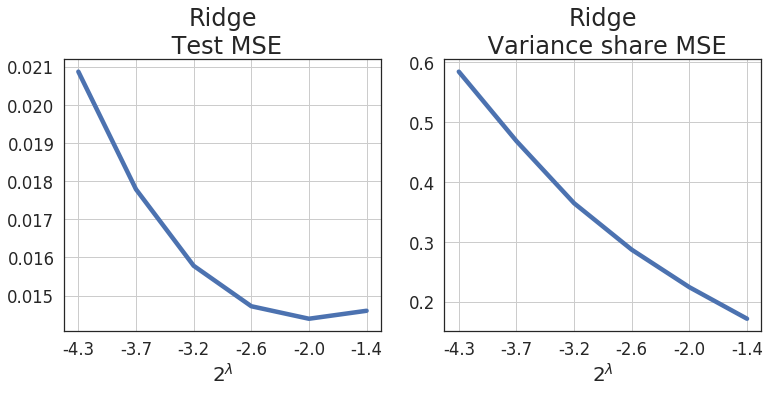

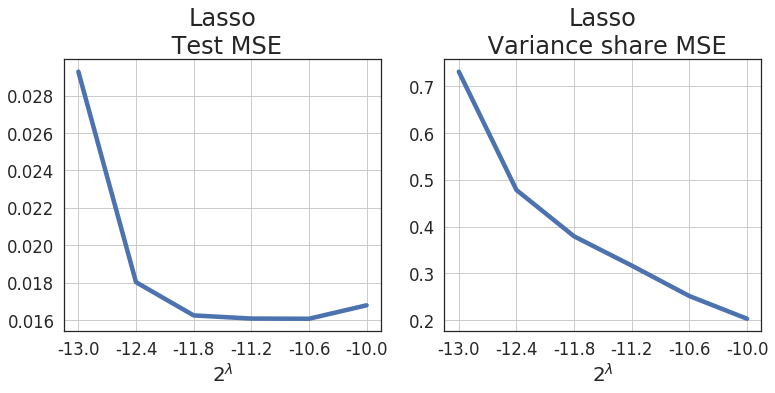

In [23]:
fontSize  = 16
legends = ['OLS', r'Ridge $\lambda=$ %g' %ridgeLambda, 'Lasso']# r'Lasso $\lambda=$ %g' %lassoLambda] #, 'Bootstrap MSE', 'K-fold MSE'
legends = ['OLS','Ridge', 'Lasso']

mseMethods =  mseTrainingLs, mseTrainingRidge, mseTrainingLasso
mseMethodsTesting =  mseKFLs, mseKFRidge, mseKFLasso
biasVariance =  np.array(varianceRealDataKFLs)/np.array(totalMSErealDataKFLs), \
                np.array(varianceRealDataKFRidge)/np.array(totalMSErealDataKFRidge),\
                np.array(varianceRealDataKFLasso)/np.array(totalMSErealDataKFLasso)
xTicks = np.arange(1,maxDegree+1, 1)
lastDegree = 5

lambdaForPlot = [ridgeLambdas, lassoLambdas]
modelNames = ['Ridge', 'Lasso']

for method in range(len(lambdaForPlot)):
#for trainingMethod, testingMethod, bvModel, label in zip(mseMethods, mseMethodsTesting, biasVariance, legends): # mseTrainingBS, mseTrainingKF,
    #ax.plot(ridgeLambdas[:lastDegree], trainingMethod[:lastDegree])#, label=label)
    #ax2.plot(ridgeLambdas, testingMethod)#, label=label)
    #ax3.plot(degrees[:lastDegree], bvModel[:lastDegree])
    fig, (ax,ax2) = plt.subplots(1,2, figsize=(12.5,5))  # 1 row, 2 columns

    ax.plot(np.log2(lambdaForPlot[method]), mseMethodsTesting[method+1])#, label=label)
    ax2.plot(np.log2(lambdaForPlot[method]), biasVariance[method+1])#, label=label)


    ax.set_title(modelNames[method]+'\n Test MSE', fontsize = fontSize*1.5)
    ax.set_xlabel(r'$2^\lambda$', fontsize = fontSize*1.25)
    ax.set_xticks(np.log2(lambdaForPlot[method]))
        
    ax2.set_title(modelNames[method]+'\n Variance share MSE', fontsize = fontSize*1.5)
    ax2.set_xlabel(r'$2^\lambda$', fontsize = fontSize*1.25)
    ax2.set_xticks(np.log2(lambdaForPlot[method]))
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))



    '''
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
    ax.legend(legends, loc='center left', bbox_to_anchor=(-0.1, -0.45), \
               fontsize = fontSize, ncol=2)
    ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)


    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
    ax2.legend(legends, loc='center left', bbox_to_anchor=(-0.1, -0.45), \
               fontsize = fontSize, ncol=2)
    ax2.tick_params(axis='both', which='major', labelsize=fontSize*1.25)
    plt.tight_layout()
    '''

The top row in the figures above shows the test MSE and variance share of MSE for the Ridge estimator for different punishment parameters. The second row in the above plot shows the same as the first row, but now for the Lasso estimator. <br>

For Ridge we see that an optimum $\lambda_{Ridge}^*$ is reached for $\lambda = 0.2$. From the rigth figure in the first row we see that the variance share of MSE is reduced when the punishment parameter increases. The increase in the variance share with punishment parameter size was expected. The model becomes more simple, and hence less sensitive to changes in test set when the punishment parameter is increased. The parameter values are lower when the punishment parameter is high. <br>

From the bottom row in the figure above, which shows the test MSE and the variance share of MSE for Lasso, shows that the story is the same for Lasse it was for Ridge. There is an optimum punishment parameter size, $\lambda_{Lasso}^* = 0.00025$, that minimizes test MSE. <br>

By comparing the first column of plots in the figure above, we see that the Ridge regression seems to outperform Lasso when it comes to minimizing the test MSE. Since both the Ridge and the Lasso estimators for optimal punishment parameters  outperforms OSL, the overall ranking of the models from best to worst are: Ridge, Lasso, OLS.

### The effect of noise
Til now we have used the pure Franke-function as input to our data without any extra noise. If the Franke-function had been in the Span of our basis functions, we would have gotten a perfect fit with zero error. However, our basis functions do not span the Franke-function. Hence we do not get a perfect fit. There will always be an error. This error does probably not have the same properties as the usual NIID (Normally Independent Individually Distributed) noise term one uses to assume. <br>

In order to see what the effect of noise is on the estimators, we now add more noise, of the NIID type, to the data. THe following code produces the following figures.

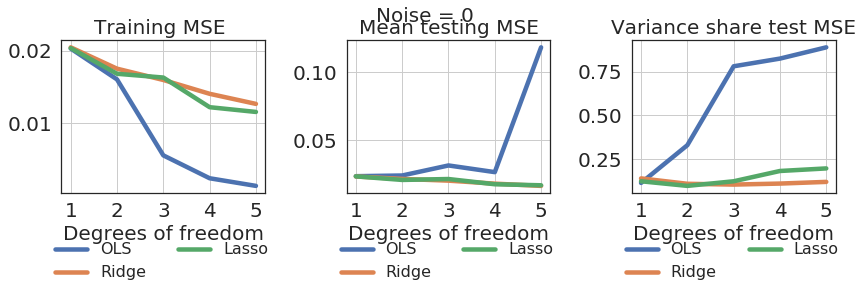

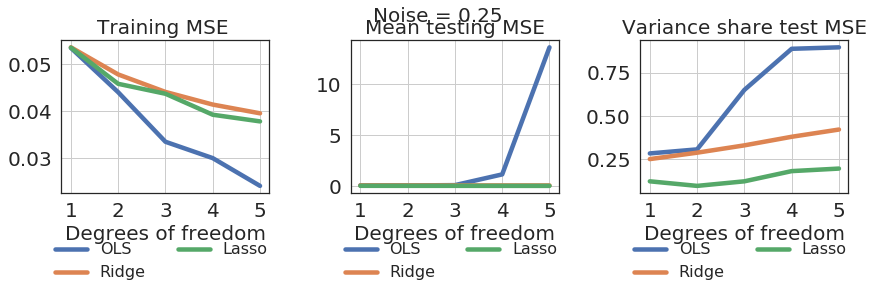

In [24]:
noises = 0., 0.25
for noise in noises:
    mseAllModels(noise=noise)

In the figure above, the top row shows MSE measures in the absence of noise, while the bottom row shows the same in presence of noise. <br>

By comparing the first and second row of the first column in the figure above, we see that adding noise increaes the training MSE for all models. Furthermore the relationship between the different models training MSE does not seem to change with noise. <br>

From the middle column we see that adding noise increases the testing MSE of the OLS-model significanlty, while the testing MSE of the other models is much less affected. <br>

From the third column in the figure above we see that the variance share of test MSE is little affected by noise for the OLS-model and the Lasso-model. The variance share of the Ridge model, on the other hand, is affected by the noise. When there is no extra noise, the Ridge model has the lowest variance share of test MSE. In the presence of extra noise, the variance share of the Ridge model increaes significantly with model complexity and becomes larger than for the Lasso model. This reflects the effect of Lasso being able to set parameters to zero, while this is not fully possible with Ridge. Hence the Ridge model can be more sensitive to noise than the Lasso model.

## Bias-variance trade-off
### Bootstrap Bias-variance

In [ ]:
np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

def frankeNoise(z, noiseSize):
    return z+ noiseSize*np.random.randn(len(z))

noiseSize  = 0.5

zPlot = frankeNoise(zPlot, noiseSize)

maxDegree = 15
degrees = np.arange(1, maxDegree)
bootstraps = 10
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

In [ ]:
fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees[:-1], variables[i][:-1], label=legends[i][:-1])
fig.legend(legends)

### K-fold bias-variance

In [ ]:
# Testing K-fold

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)

maxDegrees = 10
degrees = np.arange(1,maxDegrees+1)
bias, variance, noise, totalError = [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.predict()
    ls.kFold(numberOfFolds=10)
    ls.mseSciKit
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)    
display_scores(ls.mseSciKit)

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, )


### Bootstrap other function

In [ ]:
# Testing other function
def f(x, y):
    #z = 2 * np.sin(x * 1.5)
    z = x**2
    return z

def fWithNoise(z):
    z = z+ 5.*np.random.randn(len(z))
    return z

observationNumber = 20
x = np.linspace(0, 4.5, observationNumber)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

fig, ax  = plt.subplots()
z2 = f(x,y)
ax.plot(x, z2)
ax.plot(x, fWithNoise(z2))


xPlot, yPlot = np.meshgrid(x,y)
zPlot = f(xPlot, yPlot)
zPlot = fWithNoise(zPlot)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xPlot, yPlot, zPlot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



maxDegrees = 11
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
for degree in degrees:
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=f)
    #ls.createDesignMatrix()
    #ls.estimate()
    #ls.fit()
    #ls.predict()
    #ls.plot()
    #ls.calculateErrorScores()
    #ls.calculateVarianceBeta()
    ls.errorBootstrap(bootstraps=bootstraps, plot=False)
    bias.append(ls.bias2)
    variance.append(ls.variance)
    noise.append(ls.noise)
    totalError.append(ls.totalError)
    totalErrorForTesting.append(ls.totalErrorForTesting)
    totalError2.append(ls.error2)
print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError, \
      '\n totalErrorForTesting', totalErrorForTesting, '\n totalError2', totalError2, )

fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total']
variables = [bias, variance, noise, totalError]
for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

In [ ]:
fig, ax = plt.subplots()
legends = ['Bias', 'Variance', 'Noise', 'Total', 'noise2']
noiseFromOther = [totalError[i]-(bias[i] + variance[i]) for i in range(len(totalError))]
variables = [bias, variance, noise, totalError, noiseFromOther]

for i in range(len(variables)):
    ax.plot(degrees, variables[i], label=legends[i])
fig.legend(legends)

# Ridge

In [ ]:
degree = 10
lambdaValues = 0, .1, 1., 10, 100
for lambdaValue in lambdaValues:
    print('\n Lambda %.2f' %lambdaValue, '\n')
    ls = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
    ls.createDesignMatrix()
    ls.estimate()
    #print('betaHat my class: \n', ls.betaHat)
    ls.predict()
    ls.calculateErrorScores()

In [ ]:
# Ridge and bootstrap
maxDegrees = 10
degrees = np.arange(1, maxDegrees)
bootstraps = 100
bias, variance, noise, totalError, totalErrorForTesting, totalError2 = [], [], [], [], [], []
lambdaValues = 0, 10
noiseValues = 0, 0.5
for noiseValue in noiseValues:
    print('\n Noise: %.2f' %noiseValue, '\n')
    zPlotInput = frankeNoise(zPlot, noiseValue)
    for lambdaValue in lambdaValues:
        print('\n Lambda %.2f' %lambdaValue, '\n')
        for degree in degrees:
            ls = LeastSquares(xPlot, yPlot, zPlotInput, degree,trueFunction=FrankeFunction, lambdaValue=lambdaValue)
            #ls.createDesignMatrix()
            #ls.estimate()
            #ls.predict()
            #ls.plot()
            #ls.calculateErrorScores()
            #ls.calculateVarianceBeta()
            ls.errorBootstrap(bootstraps=bootstraps, plot=False)
            bias.append(ls.bias2)
            variance.append(ls.variance)
            noise.append(ls.noise)
            totalError.append(ls.totalError)
        print('\n bias', bias, '\n variance', variance, '\n noise', noise, '\n totalError', totalError,'\n' )

# Sci-kit learn comparisons
This section includes comparison of our own methods with corresponding Sci-Kit learn methods.


### K-fold: MSE. Own vs sci-kit

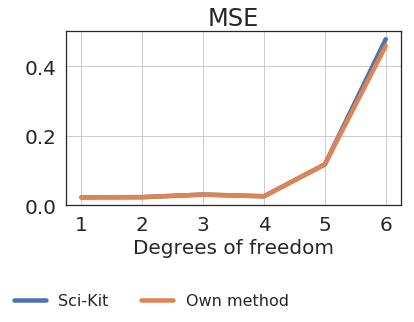

In [17]:
# Sci-kit learn Cross validation

from sklearn.linear_model import LinearRegression

np.random.seed(1)
observationNumber = 20
x = np.random.rand(observationNumber, 1)
x = np.sort(x, 0)
y = np.random.rand(observationNumber, 1)
y = np.sort(y, 0)

#x = np.linspace(0,1,5)
#y = np.linspace(0,1,5)
xPlot, yPlot = np.meshgrid(x,y)
zPlot = FrankeFunction(xPlot, yPlot)
x = np.reshape(xPlot, -1, 1)
y = np.reshape(yPlot, -1, 1)
z = np.reshape(zPlot, -1, 1)


def display_scores(scores):
    #print("Scores:", scores)
    #print("Mean:", scores.mean())
    #print("Standard deviation:", scores.std())
    return  scores.mean(), scores.std()

mses = []
mseKF = []
error = []
maxDegrees = 6
numberOfFolds = 10
linreg = LinearRegression()

for degree in range(1, maxDegrees+1):
    poly = PolynomialFeatures(degree)
    XHat = np.c_[x, y]
    XHat = poly.fit_transform(XHat)
    lin_scores = cross_val_score(linreg, XHat, z,
                             scoring="neg_mean_squared_error", cv=numberOfFolds)
    lin_rmse_scores = -lin_scores
    mse, std = display_scores(lin_rmse_scores)
    mses.append(mse)
    
    lsKF = LeastSquares(xPlot, yPlot, zPlot, degree,trueFunction=FrankeFunction)
    lsKF.kFold(numberOfFolds=numberOfFolds)
    mseKF.append(np.mean(lsKF.mseSciKit))
    error.append(lsKF.totalError)

#print('\n Manually calculated MSE/ MSE sci-kit-function  \n', np.array(error)/np.array(mseKF))
    
degrees = np.arange(1, maxDegrees+1)
fig, ax = plt.subplots()
legends = ['Sci-Kit', 'Own method']#
methods = mses, mseKF#, error
for degree, method, label in zip(range(1, maxDegrees+1), methods, legends):
    ax.plot(degrees, method, label=label)
#fig.legend(legends)


ax.set_title('MSE', fontsize = fontSize*1.5)
ax.set_xlabel('Degrees of freedom', fontsize = fontSize*1.25)
ax.set_xticks(degrees)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 1.0, box.height*.8])
ax.legend(legends, loc='center left', bbox_to_anchor=(-0.2, -0.55), \
           fontsize = fontSize, ncol=2)
ax.tick_params(axis='both', which='major', labelsize=fontSize*1.25)